In [1]:
import operator
import math
import random
import sys
import time

import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from IPython.display import clear_output

In [2]:
#@title Setup Fitness Criteria
#GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("IndGA", list, fitness=creator.FitnessMax)
#GP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [3]:
#@title Use Boston Housing dataset as input regression set
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
X = np.swapaxes(X,0,1)
inputs = X.shape[0]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets includ

In [4]:
#@title Code to Inspect Dataset
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
#@title Add Genetic Operators to Toolbox for GA feature selection
toolbox_ga = base.Toolbox()
toolbox_ga.register("float", random.uniform, -1, 1)
toolbox_ga.register("individual", tools.initRepeat, creator.IndGA, toolbox_ga.float, inputs)
toolbox_ga.register("population", tools.initRepeat, list, toolbox_ga.individual)

toolbox_ga.register("select", tools.selTournament, tournsize=3)
toolbox_ga.register("mate", tools.cxTwoPoint)
toolbox_ga.register("mutate", tools.mutGaussian, mu=0, sigma=0.01, indpb=0.05)

In [6]:
def protectedDiv(left, right):
  with np.errstate(divide='ignore',invalid='ignore'):
    x = np.divide(left, right)
    if isinstance(x, np.ndarray):
      x[np.isinf(x)] = 1
      x[np.isnan(x)] = 1
    elif np.isinf(x) or np.isnan(x):
      x = 1
  return x

#@title Create Set of Operators
pset = gp.PrimitiveSet("MAIN", inputs)
pset.addPrimitive(np.add, 2, name="vadd")
pset.addPrimitive(np.subtract, 2, name="vsub")
pset.addPrimitive(np.multiply, 2, name="vmul")
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(np.negative, 1, name="vneg")
#pset.addPrimitive(np.cos, 1, name="vcos")
#pset.addPrimitive(np.sin, 1, name="vsin")
#pset.addEphemeralConstant("rand101", lambda: random.randrange(-1000,1000))

toolbox_gp = base.Toolbox()
toolbox_gp.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox_gp.register("individual", tools.initIterate, creator.Individual, toolbox_gp.expr)
toolbox_gp.register("population", tools.initRepeat, list, toolbox_gp.individual)
toolbox_gp.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox_gp.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    p = np.expand_dims(points, axis=1)
    x = X * np.asarray(p)
    diff = math.sqrt(np.sum((func(*x.tolist()) - y)**2))
    return diff,

toolbox_gp.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox_gp.register("select", tools.selTournament, tournsize=3)
toolbox_gp.register("mate", gp.cxOnePoint)
toolbox_gp.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_gp.register("mutate", gp.mutUniform, expr=toolbox_gp.expr_mut, pset=pset)

toolbox_gp.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox_gp.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

In [7]:
#@title Code to Plot the Expression Tree
import matplotlib.pyplot as plt
import networkx as nx

def plot_expression(individual):
  options = {"node_size": 500, "alpha": 0.8}
  nodes, edges, labels = gp.graph(individual)

  g = nx.Graph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)

  pos = nx.spring_layout(g)
  nx.draw_networkx_nodes(g, pos, **options)
  nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)
  nx.draw_networkx_labels(g, pos, labels, font_size=9, font_color='k')
  plt.show()

In [8]:
#@title Run the Evolution
GA_GEN, GP_GEN, BASE_POP = 1, 10, 10000
pop_ga = toolbox_ga.population(n=BASE_POP*GA_GEN)
pop_gp = toolbox_gp.population(n=BASE_POP*GP_GEN)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "type", "evals", "std", "min", "avg", "max"

best_ga = tools.selRandom(pop_ga, 1)[0]
best_gp = tools.selRandom(pop_gp, 1)[0]

for ind in pop_gp:
    ind.fitness.values = toolbox_gp.evaluate(ind, points=best_ga)

for ind in pop_ga:
    ind.fitness.values = toolbox_gp.evaluate(best_gp, points=ind)

record = stats.compile(pop_ga)
logbook.record(gen=0, type='ga', evals=len(pop_ga), **record)

record = stats.compile(pop_gp)
logbook.record(gen=0, type='gp', evals=len(pop_gp), **record)

8  	ga  	10000 	47295.8    	174.922	18141.2    	773422     
8  	gp  	100000	1.35642e+07	134.291	191824     	3.27352e+09


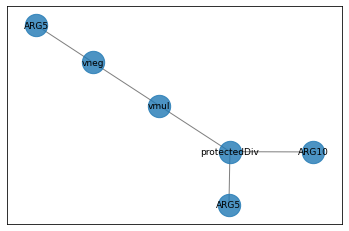

Best GA ['-0.23', '0.84', '0.49', '0.02', '-0.05', '-0.51', '-0.82', '0.59', '0.97', '-0.64', '-0.00', '-0.93', '-1.00']
Best individual GA is [-0.2280018402641022, 0.8420403277476478, 0.4932921435059261, 0.023567737160838043, -0.054957321074538656, -0.5065200645927588, -0.8181038163600538, 0.5908868768300104, 0.9652662504536682, -0.6431143784503617, -0.0005570454889307977, -0.9308796921188041, -0.9972440719290232], (773422.3278990088,)
Best individual GP is vmul(protectedDiv(ARG5, ARG10), vneg(ARG5)), (134.29073125883824,)


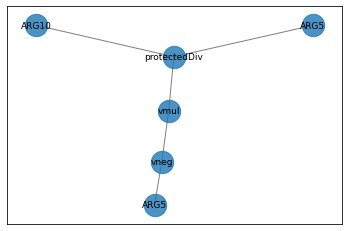

In [9]:

print(logbook.stream)

CXPB, MUTPB, NGEN = 0.5, 0.2, 100

done = False
# Begin the evolution
for g in range(1, NGEN):
    if done: break

    if (g+1) % GA_GEN == 0:
      # Select and clone the offspring
      off_ga = toolbox_ga.select(pop_ga, len(pop_ga))
      off_ga = [toolbox_ga.clone(ind) for ind in off_ga]

      # Apply crossover and mutation
      for ind1, ind2 in zip(off_ga[::2], off_ga[1::2]):
          if random.random() < CXPB:
              toolbox_ga.mate(ind1, ind2)
              del ind1.fitness.values
              del ind2.fitness.values

      for ind in off_ga:
          if random.random() < MUTPB:
              toolbox_ga.mutate(ind)
              del ind.fitness.values

      pop_ga = off_ga

    if (g+1) % GP_GEN == 0:
      off_gp = toolbox_gp.select(pop_gp, len(pop_gp))
      off_gp = [toolbox_gp.clone(ind) for ind in off_gp]

      for ind1, ind2 in zip(off_gp[::2], off_gp[1::2]):
          if random.random() < CXPB:
              toolbox_gp.mate(ind1, ind2)
              del ind1.fitness.values
              del ind2.fitness.values

      for ind in off_gp:
          if random.random() < MUTPB:
              toolbox_gp.mutate(ind)
              del ind.fitness.values

      # Replace the old population by the offspring
      pop_gp = off_gp

    # Evaluate the individuals with an invalid fitness
    for ind in pop_gp:
        ind.fitness.values = toolbox_gp.evaluate(ind, points=best_ga)
    for ind in pop_ga:
        ind.fitness.values = toolbox_gp.evaluate(best_gp, points=ind)

    record = stats.compile(pop_ga)
    best_ga_min = record["min"]
    logbook.record(gen=g, type='ga', evals=len(pop_ga), **record)

    record = stats.compile(pop_gp)
    best_gp_min = record["min"]
    logbook.record(gen=g, type='gp', evals=len(pop_gp), **record)
    #print(logbook.stream)
    print(record)

    best_ga = tools.selBest(pop_ga, 1)[0]
    best_gp = tools.selBest(pop_gp, 1)[0]

    if best_gp_min < 135:
        done = True
        print("Sovled")

    if (g+1) % 1 == 0:
      clear_output()
      print(logbook.stream)
      plot_expression(best_gp)
      output = ["%.2f" % e for e in best_ga]
      print(f"Best GA {output}")
      time.sleep(1)

print("Best individual GA is %s, %s" % (best_ga, best_ga.fitness.values))
print("Best individual GP is %s, %s" % (best_gp, best_gp.fitness.values))
plot_expression(best_gp)